In [20]:
from pymongo import MongoClient
import pandas as pd
import time
import requests
import json
from getpass import getpass
import os
import folium
from folium import Choropleth, Circle, Marker, Icon, Map
from folium.plugins import HeatMap, MarkerCluster
import geopandas as gpd
from cartoframes.viz import Map, Layer, popup_element
from dotenv import load_dotenv
import matplotlib.pyplot as plt

In [21]:
token = os.getenv("token")

In [22]:
load_dotenv()

True

In [23]:
client = MongoClient("localhost:27017")
client

db = client["Ironhack"]
c = db.get_collection("companies")

### Checkiing number of employees

In [24]:
filter_1 = {"number_of_employees" :{"$gte":77, "$lte": 100}}
projection = {"name":1, "offices.country_code": 1, "offices.city": 1, "number_of_employees":1, "_id": 0}

results1 = list(c.find(filter_1, projection).sort("number_of_employees", 1))
companies= pd.DataFrame(results1)

### Adding more filters, category games_video, web and design, raised amount

In [25]:
filter_2 = {
    "$or": [
        {
            "$and": [
                {"category_code": "games_video"},
                {"funding_rounds": {"$elemMatch": {"raised_amount": {"$gte": 1000000}}}},
                {"number_of_employees": {"$gte": 77, "$lte": 100}}
            ]
        },
        {"category_code": "web"},
        {"category_code": "design"}
    ]
}

projection = {
    "name": 1,
    "funding_rounds.raised_amount": 1,
    "number_of_employees": 1,
    "offices.country_code": 1,
    "offices.city": 1,
    "category_code": 1,
    "offices.latitude": 1,
    "offices.longitude": 1,
    "_id": 0
}

results2 = list(c.find(filter_2, projection).sort("category_code", -1))
df = pd.DataFrame(results2)
df


,name,category_code,number_of_employees,funding_rounds,offices
0,Wetpaint,web,47.0,"[{'raised_amount': 5250000}, {'raised_amount':...","[{'city': 'Seattle', 'country_code': 'USA', 'l..."
1,Postini,web,NaN,[],"[{'city': 'San Carlos', 'country_code': 'USA',..."
2,Geni,web,18.0,"[{'raised_amount': 1500000}, {'raised_amount':...","[{'city': 'West Hollywood', 'country_code': 'U..."
3,Fox Interactive Media,web,0.0,[],"[{'city': 'Beverly Hills', 'country_code': 'US..."
4,StumbleUpon,web,NaN,"[{'raised_amount': 1500000}, {'raised_amount':...","[{'city': 'San Francisco', 'country_code': 'US..."
...,...,...,...,...,...
3792,Exent,games_video,100.0,[{'raised_amount': 3000000}],"[{'city': 'New York', 'country_code': 'USA', '..."
3793,99designs,design,100.0,[{'raised_amount': 35000000}],"[{'city': 'San Francisco', 'country_code': 'US..."
3794,Graticle,design,1.0,[],"[{'city': 'Ellensburg', 'country_code': 'USA',..."
3795,Kickstarter,design,NaN,[{'raised_amount': 10000000}],"[{'city': 'Brooklyn', 'country_code': 'USA', '..."


### Separating column offices, to be able to check countries and cities, we also add latitude and longitude

In [26]:
cities = []
country_codes = []
latitudes = []
longitudes = []

for index, row in df.iterrows():
    office_info = row['offices']
    if isinstance(office_info, list) and len(office_info) > 0:
        city = office_info[0].get('city', None)
        country_code = office_info[0].get('country_code', None)
        latitude = office_info[0].get('latitude', None)
        longitude = office_info[0].get('longitude', None)
    else:
        city = None
        country_code = None
        latitude = None
        longitude = None
    cities.append(city)
    country_codes.append(country_code)
    latitudes.append(latitude)
    longitudes.append(longitude)

df['city'] = cities
df['country_code'] = country_codes
df['latitude'] = latitudes
df['longitude'] = longitudes
df 

,name,category_code,number_of_employees,funding_rounds,offices,city,country_code,latitude,longitude
0,Wetpaint,web,47.0,"[{'raised_amount': 5250000}, {'raised_amount':...","[{'city': 'Seattle', 'country_code': 'USA', 'l...",Seattle,USA,47.603122,-122.333253
1,Postini,web,NaN,[],"[{'city': 'San Carlos', 'country_code': 'USA',...",San Carlos,USA,37.506885,-122.247573
2,Geni,web,18.0,"[{'raised_amount': 1500000}, {'raised_amount':...","[{'city': 'West Hollywood', 'country_code': 'U...",West Hollywood,USA,34.090368,-118.393064
3,Fox Interactive Media,web,0.0,[],"[{'city': 'Beverly Hills', 'country_code': 'US...",Beverly Hills,USA,34.076179,-118.394170
4,StumbleUpon,web,NaN,"[{'raised_amount': 1500000}, {'raised_amount':...","[{'city': 'San Francisco', 'country_code': 'US...",San Francisco,USA,37.775196,-122.419204
...,...,...,...,...,...,...,...,...,...
3792,Exent,games_video,100.0,[{'raised_amount': 3000000}],"[{'city': 'New York', 'country_code': 'USA', '...",New York,USA,40.752380,-74.005568
3793,99designs,design,100.0,[{'raised_amount': 35000000}],"[{'city': 'San Francisco', 'country_code': 'US...",San Francisco,USA,37.795531,-122.400598
3794,Graticle,design,1.0,[],"[{'city': 'Ellensburg', 'country_code': 'USA',...",Ellensburg,USA,45.796841,-122.693144
3795,Kickstarter,design,NaN,[{'raised_amount': 10000000}],"[{'city': 'Brooklyn', 'country_code': 'USA', '...",Brooklyn,USA,NaN,NaN


In [27]:
df = df.drop('offices', axis=1, inplace=False)

In [28]:
df

,name,category_code,number_of_employees,funding_rounds,city,country_code,latitude,longitude
0,Wetpaint,web,47.0,"[{'raised_amount': 5250000}, {'raised_amount':...",Seattle,USA,47.603122,-122.333253
1,Postini,web,NaN,[],San Carlos,USA,37.506885,-122.247573
2,Geni,web,18.0,"[{'raised_amount': 1500000}, {'raised_amount':...",West Hollywood,USA,34.090368,-118.393064
3,Fox Interactive Media,web,0.0,[],Beverly Hills,USA,34.076179,-118.394170
4,StumbleUpon,web,NaN,"[{'raised_amount': 1500000}, {'raised_amount':...",San Francisco,USA,37.775196,-122.419204
...,...,...,...,...,...,...,...,...
3792,Exent,games_video,100.0,[{'raised_amount': 3000000}],New York,USA,40.752380,-74.005568
3793,99designs,design,100.0,[{'raised_amount': 35000000}],San Francisco,USA,37.795531,-122.400598
3794,Graticle,design,1.0,[],Ellensburg,USA,45.796841,-122.693144
3795,Kickstarter,design,NaN,[{'raised_amount': 10000000}],Brooklyn,USA,NaN,NaN


In [29]:
file_path = r"C:\Users\photo\Desktop\Ironhack\projects\project-III-geolocation\data\companies_cleaned.csv"
df.to_csv(file_path, index=True)

### Choosing company country by filered data

In [30]:
value_counts = df['country_code'].value_counts()
print("Conteo de valores únicos en 'mi_columna':")
print(value_counts)

Conteo de valores únicos en 'mi_columna':
country_code
USA    1851
GBR     212
CAN     111
IND      69
FRA      68
       ... 
KEN       1
PER       1
NIC       1
BGR       1
PRI       1
Name: count, Length: 66, dtype: int64


### Creating a plot for the presentation

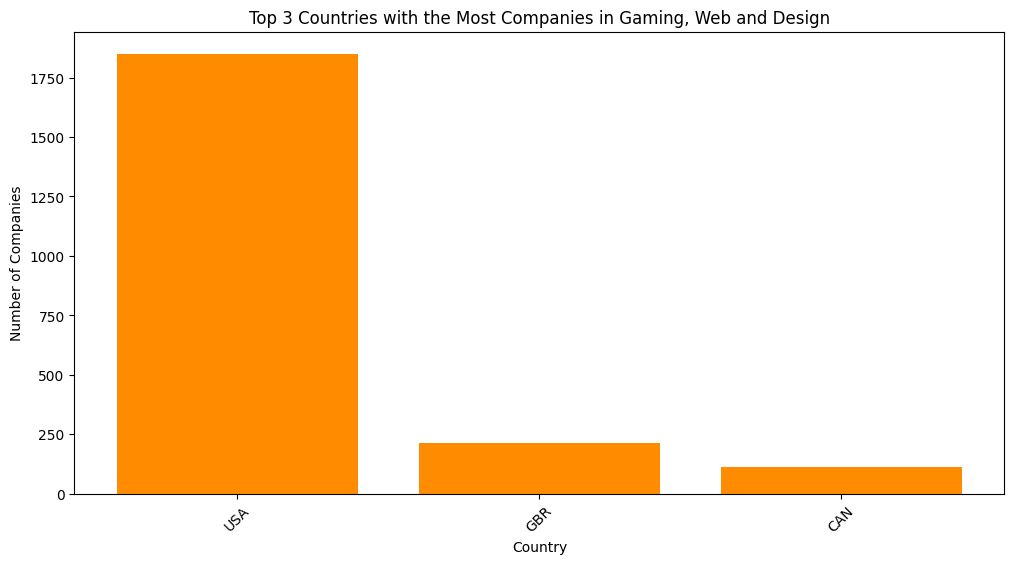

In [41]:
value_counts = df['country_code'].value_counts()

top_10_countries = value_counts.head(3)

plt.figure(figsize=(12, 6))
plt.bar(top_10_countries.index, top_10_countries, color='darkorange')
plt.title('Top 3 Countries with the Most Companies in Gaming, Web and Design')
plt.xlabel('Country')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)  
plt.gca().set_facecolor('white') 

file_path = r'C:\Users\photo\Desktop\Ironhack\projects\project-III-geolocation\images\top_10_countries'
plt.savefig(file_path, bbox_inches='tight', dpi=300)
plt.show()

## We count the number of gaming, web and design companies in USA by the top 2 cities as we only want one.

In [32]:
filtered_df = df[df['country_code'] == 'USA']

city_counts = filtered_df['city'].value_counts().to_dict()

sorted_city_counts = dict(sorted(city_counts.items(), key=lambda item: item[1], reverse=True))

for city, count in list(sorted_city_counts.items())[:2]:
    print(f"City: {city}, Number of gaming, web and design companies in the USA: {count}")

City: San Francisco, Number of gaming, web and design companies in the USA: 199
City: New York, Number of gaming, web and design companies in the USA: 170


### We create a plot for the presentation

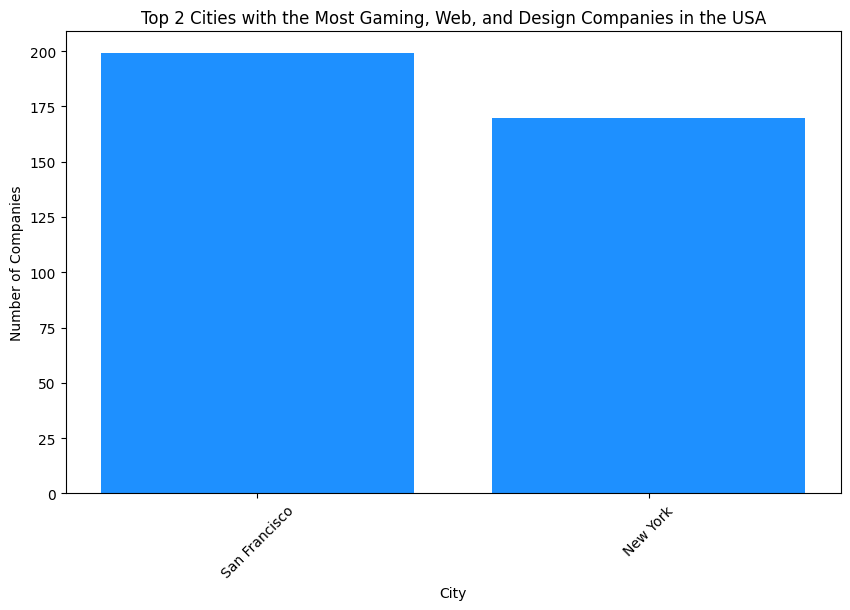

In [40]:
filtered_df = df[df['country_code'] == 'USA']

city_counts = filtered_df['city'].value_counts().to_dict()

sorted_city_counts = dict(sorted(city_counts.items(), key=lambda item: item[1], reverse=True)[:2])

cities = list(sorted_city_counts.keys())
counts = list(sorted_city_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(cities, counts, color='dodgerblue')
plt.title('Top 2 Cities with the Most Gaming, Web, and Design Companies in the USA')
plt.xlabel('City')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)  

file_path = r'C:\Users\photo\Desktop\Ironhack\projects\project-III-geolocation\images\top2_cities'
plt.savefig(file_path, bbox_inches='tight', dpi=300)
plt.show()